In [44]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5

import astropy.units as u

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [72]:
sn_iso = {}
sn = {}
for num in tqdm([0, 50, 100, 150, 200, 250, 300, 350, 400]):
    sn_iso[num] = arepo.Snapshot(basepath + '/runs/MW4iso_fg0.2_MHG0.15_RC9/lvl4/output/', num, combineFiles=True)
    sn[num] = arepo.Snapshot(basepath + '/runs/MW4_MHG0.15_GSE6_kick/lvl4/output/', num, combineFiles=True)    

100%|██████████| 9/9 [00:36<00:00,  4.07s/it]


In [41]:
center = np.array([200, 200, 200])

PROTONMASS = 1.67262178e-24
HYDROGEN_MASSFRAC = 0.76
G = 43018.7

def get_Menc(sn, renc, center = np.array([200, 200, 200])):
    Menc = 0.0
    for i in range(5):
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            
            pos = part.pos.value - center
            r = np.linalg.norm(pos, axis=1)
            
            enc = r < renc
            if sn.MassTable[i] > 0.0:
                Menc += sn.MassTable[i].value * len(np.where(enc)[0])
            else:
                Menc += np.sum(part.mass.value[enc])
    
    return Menc
            
if True:
    snap = 200
    
    UnitLength = sn[snap].parameters.UnitLength_in_cm
    UnitMass = sn[snap].parameters.UnitMass_in_g
    UnitVelocity = sn[snap].parameters.UnitVelocity_in_cm_per_s

    r0 = 40
    dr = 1

    pos = sn[snap].part0.pos.value - center
    r = np.linalg.norm(pos, axis=1)
    
    in_shell = np.logical_and(r > r0 - dr/2., r < r0 + dr/2.)
    
    Lambda = np.mean(sn[snap].part0.GFM_CoolingRate.value[in_shell])
    Menc = get_Menc(sn[snap], r0)
    vcsq = G * Menc / r0
    print(np.sqrt(vcsq))
    
    # convert to cgs
    # vcsq_cgs = vcsq * UnitVelocity**2
    # r0_cgs = r0 * UnitLength
    
    vcsq *= (u.km/u.s)**2
    r0 *= u.kpc
    mp = PROTONMASS * u.g
    Lambda *= u.cm**3 * u.erg / u.s
    
    Mdotmax = (4 * np.pi * mp**2 * vcsq**2 * r0)/(HYDROGEN_MASSFRAC**2 * Lambda)


116.67324015329243


In [45]:
Lambda

<Quantity -2.1830186e-23 cm3 erg / s>

In [46]:
def get_n_T(sn):
    UnitLength = sn.parameters.UnitLength_in_cm
    UnitMass = sn.parameters.UnitMass_in_g
    UnitVelocity = sn.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

    InternalEnergy = sn.part0.InternalEnergy.value
    ElectronAbundance = sn.part0.ElectronAbundance
    Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [66]:
COM = np.load(basepath + 'anlys/COM/COM_MW4_MHG0.15_GSE6_kick-lvl4.npy', allow_pickle=True).item()

In [74]:
n = {}
T = {}
r = {}
m = {}

for snap in sn.keys():
    n[snap], T[snap] = get_n_T(sn[snap])
    center = COM['MW_COM'][snap]
    r[snap] = np.linalg.norm(sn[snap].part0.pos.value - center, axis=1)
    m[snap] = sn[snap].part0.mass.value

n_iso = {}
T_iso = {}
r_iso = {}
m_iso = {}
    
for snap in sn_iso.keys():
    n_iso[snap], T_iso[snap] = get_n_T(sn_iso[snap])
    center = np.array([200, 200, 200])
    r_iso[snap] = np.linalg.norm(sn_iso[snap].part0.pos.value - center, axis=1)
    m_iso[snap] = sn_iso[snap].part0.mass.value
    

In [80]:
Mcold = []
Mcold_iso = []
for snap in sn.keys():
    key = np.logical_and(r[snap] > 20, T[snap] < 3E4)
    Mcold.append(np.sum(m[snap][key]))
    
    key = np.logical_and(r_iso[snap] > 20, T_iso[snap] < 3E4)
    Mcold_iso.append(np.sum(m_iso[snap][key]))

In [81]:
print(Mcold, Mcold_iso)

[0.11687059, 0.11257508, 0.110427484, 0.10886775, 0.10577996, 0.11157553, 0.11715969, 0.1225837, 0.12006478] [0.0, 8.324337e-06, 1.6607206e-05, 3.244619e-05, 0.00025723933, 0.00078457245, 0.0021742384, 0.004605259, 0.006705475]


In [95]:
MC = {}
MC_iso = {}
for num in tqdm([0, 50, 100, 150, 200, 250, 300, 350, 400]):
    MC[num] = h5.File(basepath + 'anlys/MC/MW4_MHG0.15_GSE6_kick-lvl4/MC_Prop_'+str(num).zfill(3)+'.h5', mode='r')
    MC_iso[num] = h5.File(basepath + 'anlys/MC/MW4iso_fg0.2_MHG0.15_RC9-lvl4/MC_Prop_'+str(num).zfill(3)+'.h5', mode='r')    

100%|██████████| 9/9 [00:00<00:00, 73.32it/s]


In [89]:
for num in MC.keys():
    r = np.linalg.norm(MC[num]['PartType5/RotatedCoordinates'][:], axis=1)
    is_CGM = MC[num]['PartType5/Membership'][:] == 1
    is_cold = MC[num]['PartType5/Temperature'][:] < 3E4

    key = np.logical_and(np.logical_and(is_CGM, is_cold), r > 20)
    mass = MC[num]['Header'].attrs['TracerMass']
    
    print(mass * len(np.where(key)[0]))


0.0
0.0005596363661551987
0.0031732732290033383
0.009380285686869444
0.01558279704795682
0.023915827550975516
0.030490429579104417
0.03578822048766744
0.03585723730494127


In [99]:
def accretion_rate(MC, rmin=20):
    
    pos = MC['PartType5/RotatedCoordinates']
    vel = MC['PartType5/RotatedVelocities']
    mass = MC['Header'].attrs['TracerMass']
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    key = r > 20
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin = np.sum(mass * vr[keyin] / r[keyin])
    Mdotout = np.sum(mass * vr[keyout] / r[keyout])
    
    return MC['Header'].attrs['Time'], Mdotin, Mdotout
    

In [100]:
net = []
net_iso = []
time = []

for num in MC.keys():
    t, Min, Mout = accretion_rate(MC[num])
    net.append(Min + Mout)
    
    t, Min, Mout = accretion_rate(MC_iso[num])
    net_iso.append(Min + Mout)
    
    time.append(t)
    

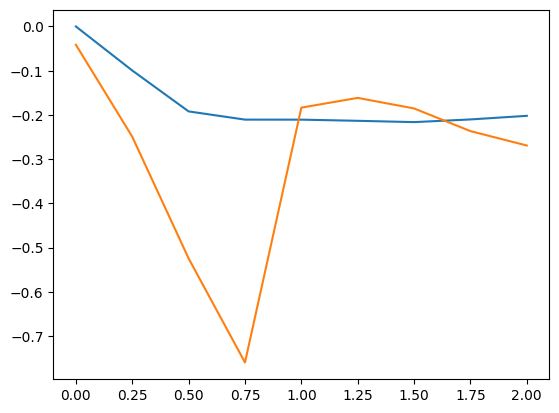

In [102]:
plt.plot(time, net_iso)
plt.plot(time, net)

In [104]:
print(np.trapz(net_iso, time))
print(np.trapz(net, time))

-0.3634147246062862
-0.613860871295642
